# Import packages

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
from scipy.stats import chi2_contingency
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import EditedNearestNeighbours
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, roc_curve, auc
from sklearn.linear_model import LinearRegression,LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
import warnings
warnings.filterwarnings("ignore")


# Load Dataset

In [2]:
df = pd.read_csv(r'D:\churn\src\notebook\data\customer_churn.csv')

# Dataset Description


In [3]:
# Dimensions of the DataFrame - rows and columns
df.shape

(7043, 21)

In [4]:
# Quick overview of the dataset
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


# Data Cleaning

In [5]:
# Get a summary of the metadata of Dataframe
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [6]:
# Check if any of the values are null
df.isnull().sum()

customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

In [7]:
# Check for non-numeric values in all numeric features of the DataFrame
numeric_cols = ['tenure', 'MonthlyCharges', 'TotalCharges']
for col in numeric_cols:
  non_numeric_rows = df[pd.to_numeric(df[col], errors='coerce').isnull()]
  print(f"Non-numeric rows for column '{col}':")
  print(len(non_numeric_rows))
  print()

Non-numeric rows for column 'tenure':
0

Non-numeric rows for column 'MonthlyCharges':
0

Non-numeric rows for column 'TotalCharges':
11



Inferences:
* The TotalCharges column contains 11 non-numeric values. To ensure data consistency, we should remove the corresponding rows that contain these values.


In [8]:
# Remove rows with non-numeric values in the 'TotalCharges' column
df = df[pd.to_numeric(df['TotalCharges'], errors='coerce').notnull()]

In [9]:
# Get the unique value count and unique values for all features in the dataset
for i, col in enumerate(df.columns):
  print(f"{i + 1}. '{col}':")
  print(f"Unique value count: {df[col].nunique()}")
  print(df[col].unique())
  print()

1. 'customerID':
Unique value count: 7032
['7590-VHVEG' '5575-GNVDE' '3668-QPYBK' ... '4801-JZAZL' '8361-LTMKD'
 '3186-AJIEK']

2. 'gender':
Unique value count: 2
['Female' 'Male']

3. 'SeniorCitizen':
Unique value count: 2
[0 1]

4. 'Partner':
Unique value count: 2
['Yes' 'No']

5. 'Dependents':
Unique value count: 2
['No' 'Yes']

6. 'tenure':
Unique value count: 72
[ 1 34  2 45  8 22 10 28 62 13 16 58 49 25 69 52 71 21 12 30 47 72 17 27
  5 46 11 70 63 43 15 60 18 66  9  3 31 50 64 56  7 42 35 48 29 65 38 68
 32 55 37 36 41  6  4 33 67 23 57 61 14 20 53 40 59 24 44 19 54 51 26 39]

7. 'PhoneService':
Unique value count: 2
['No' 'Yes']

8. 'MultipleLines':
Unique value count: 3
['No phone service' 'No' 'Yes']

9. 'InternetService':
Unique value count: 3
['DSL' 'Fiber optic' 'No']

10. 'OnlineSecurity':
Unique value count: 3
['No' 'Yes' 'No internet service']

11. 'OnlineBackup':
Unique value count: 3
['Yes' 'No' 'No internet service']

12. 'DeviceProtection':
Unique value count: 3
['N

Inferences:
* There are 7032 CustomerIds, one for each row of data.
* There are no duplicate values for any of the features.
* The 'customerID' feature is a unique identifier for each customer and does not contain any meaningful information that can be used to predict churn.

In [10]:
# Since customerID is not relevant to customer churn, drop the field
df = df.drop('customerID', axis=1)

In [11]:
# Check the datatypes of the remaining features
df.dtypes

gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges         object
Churn                object
dtype: object

Inferences:
* 'tenure' is represented as int (Months).
* 'MonthlyCharges' is represented as float.

Changes to make:
* 'SeniorCitizen' is currently represented as int, but it needs to be converted to a string to keep the types consistent.
* 'TotalCharges' is currently represented as object, but it can be represented as float.
* Binary columns can be converted to boolean data type.
* Some categorical columns can be converted to pandas 'category' data type to improve memory usage efficiency.

In [12]:
# Convert the datatypes to relevant data types

# Map 'SeniorCitizen' to a string data type
df['SeniorCitizen'] = df['SeniorCitizen'].map({1: 'Yes', 0: 'No'})

# Convert 'TotalCharges' to a float data type
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')

# List of binary attributes that should be converted to the boolean data type
bool_columns = [
    'SeniorCitizen', 'Partner', 'Dependents', 'PhoneService', 'PaperlessBilling', 'Churn'
]
# Convert binary attributes to the 'bool' data type
for col in bool_columns:
  df[col] = df[col].replace({'Yes': True, 'No': False}).astype('bool')

# List of categorical columns that should be converted to the 'category' data type
categorical_columns = [
    'gender', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup',
    'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaymentMethod'
]
# Convert categorical columns to the 'category' data type
for col in categorical_columns:
  df[col] = df[col].astype('category')

# Check the updated data types
print(df.dtypes)

gender              category
SeniorCitizen           bool
Partner                 bool
Dependents              bool
tenure                 int64
PhoneService            bool
MultipleLines       category
InternetService     category
OnlineSecurity      category
OnlineBackup        category
DeviceProtection    category
TechSupport         category
StreamingTV         category
StreamingMovies     category
Contract            category
PaperlessBilling        bool
PaymentMethod       category
MonthlyCharges       float64
TotalCharges         float64
Churn                   bool
dtype: object


In [13]:
# Get the summary of the distribution of numeric columns
numerical_cols = ['tenure', 'MonthlyCharges', 'TotalCharges']
df[numerical_cols].describe()

,tenure,MonthlyCharges,TotalCharges
count,7032.000000,7032.000000,7032.000000
mean,32.421786,64.798208,2283.300441
std,24.545260,30.085974,2266.771362
min,1.000000,18.250000,18.800000
25%,9.000000,35.587500,401.450000
50%,29.000000,70.350000,1397.475000
75%,55.000000,89.862500,3794.737500
max,72.000000,118.750000,8684.800000


# Exploratory Data Analysis

In [14]:
# Let's analyze the churn rate based on the type of information they represent:

# Customer information
group1 = ['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure']

# Services signed up for
group2 = ['PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity',
          'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies']

# Payment
group3 = ['Contract', 'PaperlessBilling', 'PaymentMethod', 'MonthlyCharges', 'TotalCharges']

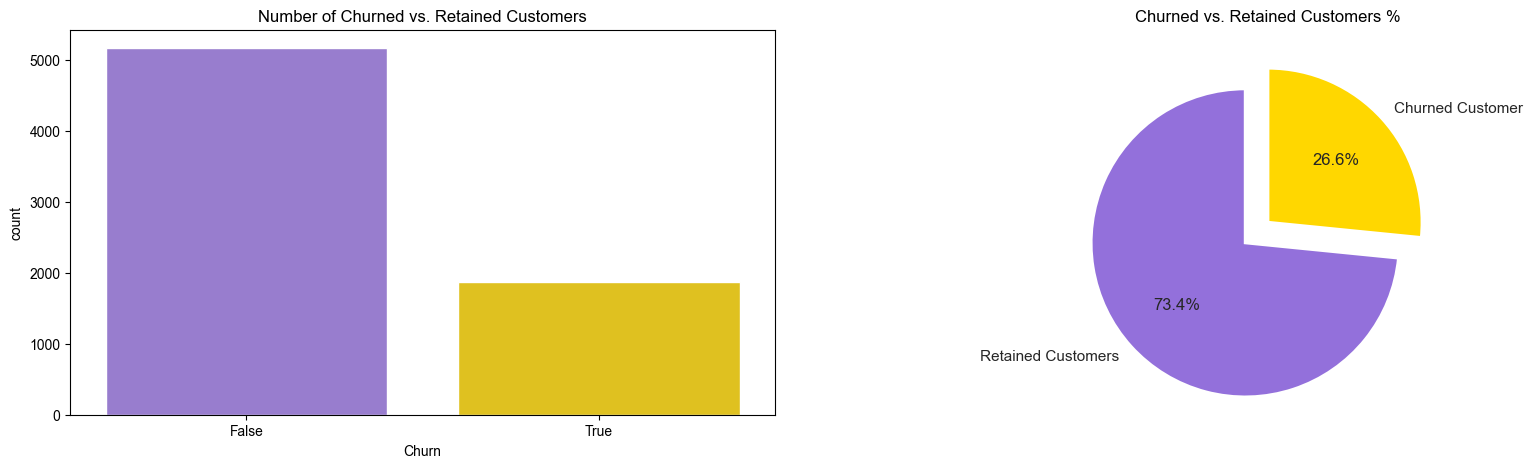

In [15]:
# Set color palette for the plots
colors = ['#9370DB','#FFD700']

# Calculate the number of occurrences for each unique value in the 'Churn' column
partList = list(df['Churn'].value_counts())
circle = [partList[0] / sum(partList) * 100, partList[1] / sum(partList) * 100]

# Create a 1x2 grid
fig = plt.subplots(nrows = 1,ncols = 2,figsize = (20,5))
# First subplot
plt.subplot(1,2,1)
sns.set_theme(style="whitegrid")
# Create a count plot using the 'Churn' column
sns.countplot(x=df["Churn"],palette=colors)
plt.title('Number of Churned vs. Retained Customers');
# Second subplot
plt.subplot(1,2,2)
# Create a pie chart using the calculated percentages from the circle list
plt.pie(circle,
        labels = ['Retained Customers','Churned Customer'],
        autopct = '%1.1f%%', startangle = 90, explode = (0.2,0), colors = colors,
        wedgeprops = {'edgecolor': 'white', 'linewidth': 2, 'antialiased' : True})
plt.title('Churned vs. Retained Customers %');
plt.show()

Inferences:
*  The plots clearly show that the number of Retained Customers is much higher than the number of Churned Customers.
* There is a significant class imbalance between Retained and Churned Customers, with a ratio of approximately 3:1.



**Helper functions to plot grid of subplots**

In [16]:
# Plots KDE plot using grid of subplots for numeric data
from scipy.stats import gaussian_kde
# Plots barplots using grid of subplots for categorized fields
def plotCategory(df, group):
  ncols = min(2, len(group))
  nrows = (len(group) + 1) // 2

  # Create a nrows x ncols grid of subplots
  fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(8 * ncols, 5 * nrows))
  axes = axes.flatten()  # Flatten axes to loop through them
  for i, col in enumerate(group):
    # Group by the current column and Churn, and calculate the counts
    column_churn_counts = df.groupby([col, 'Churn']).size().reset_index(name='counts')

    # Calculate the total counts for the current column
    column_total_counts = df.groupby(col).size().reset_index(name='total_counts')

    # Merge the two dataframes
    merged_counts = pd.merge(column_churn_counts, column_total_counts, on=col)

    # Calculate the normalized percentage of churn for the current column
    merged_counts['percentage'] = (merged_counts['counts'] / merged_counts['total_counts']) * 100

    # Plot the normalized data
    ax = axes[i]
    barplot = sns.barplot(x=col, y='percentage', hue='Churn', data=merged_counts, palette=colors, edgecolor='black', ax=ax)
    ax.set_title(f'{col} vs. Churn (Normalized)')
    ax.set_xlabel(col)
    ax.set_ylabel('Churn Percentage')
    # Add the percentage text on top of the bars
    for p in barplot.patches:
        barplot.annotate(f'{p.get_height():.1f}%', (p.get_x() + p.get_width() / 2, p.get_height()),
                         ha='center', va='baseline', fontsize=10, color='black', xytext=(0, 5), textcoords='offset points')

  if len(group) % 2 != 0:
    fig.delaxes(axes[-1])
  plt.tight_layout()
  plt.show()


def plotKDEplot(df, group):
  ncols = min(2, len(group))
  nrows = (len(group) + 1) // 2

  # Filter the data for non-churned and churned customers
  non_churned = df[df['Churn'] == 0]
  churned = df[df['Churn'] == 1]

  # Create a nrows x ncols grid of subplots
  fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(8 * ncols, 5 * nrows))
  axes = axes.flatten() if isinstance(axes, np.ndarray) else [axes]

  for i, col in enumerate(group):
      # Create a KDE plot for the current column of non-churned and churned customers
      sns.kdeplot(non_churned[col], ax=axes[i], fill=True, label='Retained', color='blue')
      sns.kdeplot(churned[col], ax=axes[i], fill=True, label='Churned', color='red')

      # Compute KDE peaks instead of using value_counts().idxmax()
      def get_kde_peak(data):
          if data.dropna().empty:
              return None
          kde = gaussian_kde(data.dropna())
          x_vals = np.linspace(data.min(), data.max(), 1000)
          y_vals = kde(x_vals)
          return x_vals[np.argmax(y_vals)]


      non_churned_peak = get_kde_peak(non_churned[col])
      churned_peak = get_kde_peak(churned[col])

      # Add vertical lines to mark the peak positions
      if non_churned_peak is not None:
          axes[i].axvline(non_churned_peak, color='blue', linestyle='--', label=f'Retained Peak: {non_churned_peak:.1f}')
      if churned_peak is not None:
          axes[i].axvline(churned_peak, color='red', linestyle='--', label=f'Churned Peak: {churned_peak:.1f}')

      axes[i].set_title(f'KDE Plot of {col} for Retained and Churned Customers')
      axes[i].set_xlabel(col)
      axes[i].set_ylabel('Density')
      axes[i].legend()

  if len(group) != 1 and len(group) % 2 != 0:
    fig.delaxes(axes[-1])
  plt.tight_layout()
  plt.show()



**Group 1 : Customer Information**

*('gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure')*



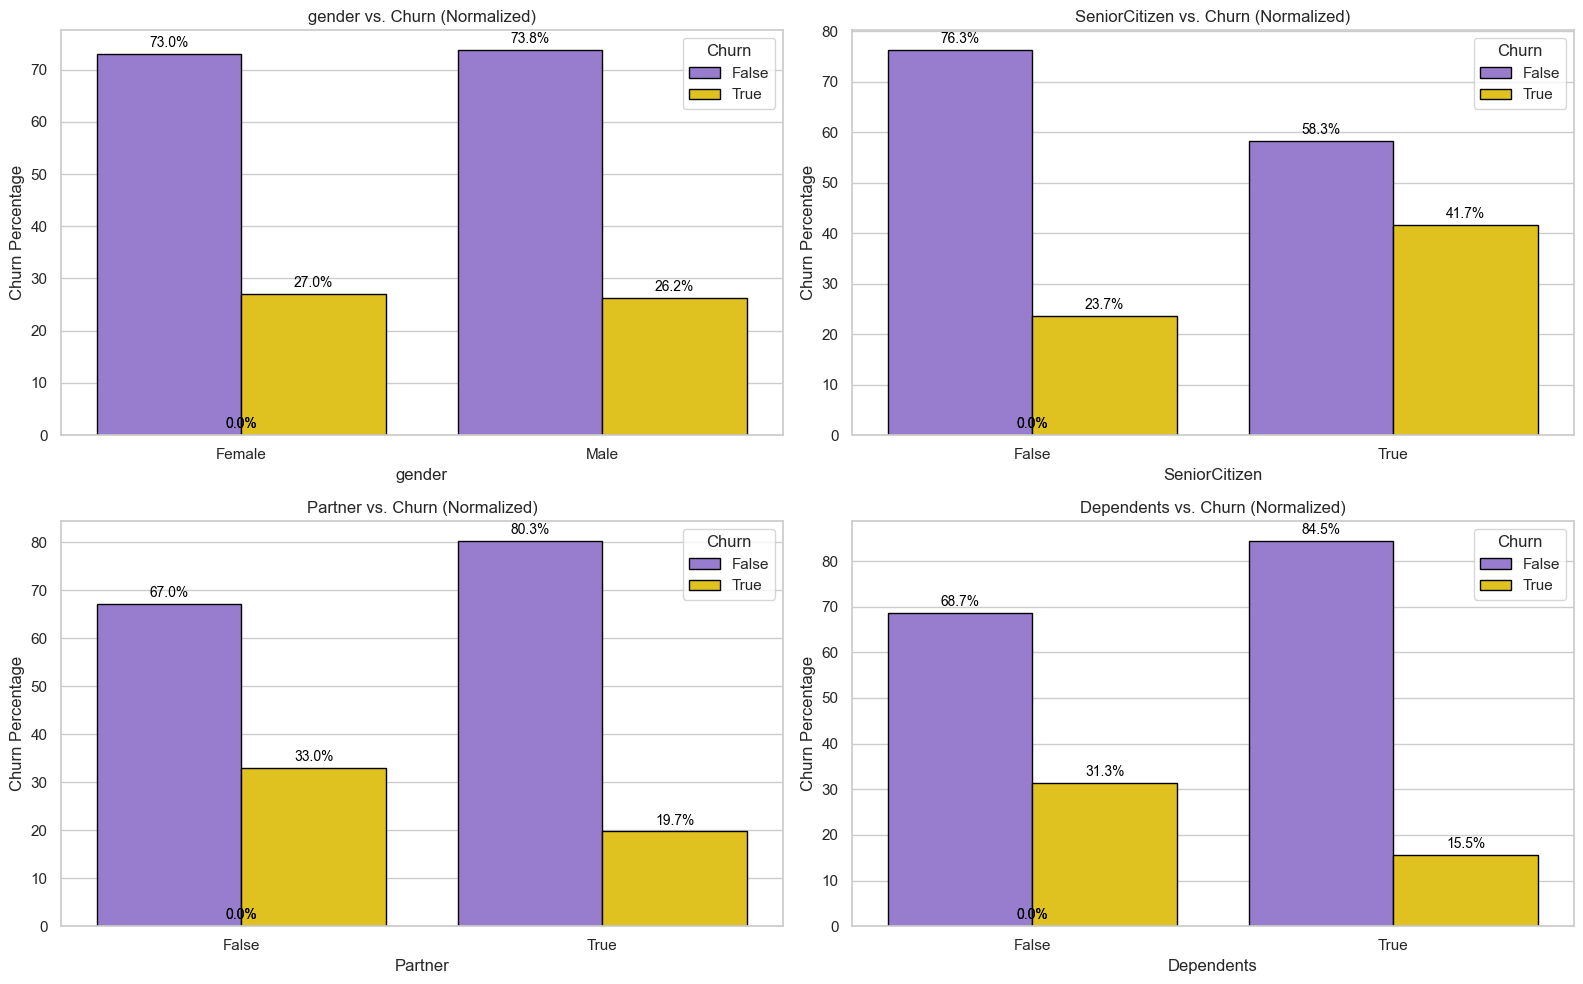

In [17]:
# Plot g1 categorized items vs Normalized Churn (except tenure)
g1 = [x for x in group1 if x != 'tenure']
plotCategory(df, g1)

Inferences:
* Gender does not seem to have a significant effect on churn, as the proportion of churned customers is similar between males and females.
* SeniorCitizens churn at a higher rate.
* Customers with a Partner are less likely to churn compared to customers without a Partner.
* Customers who do not have Dependents are more likely to churn than customers with Dependents.


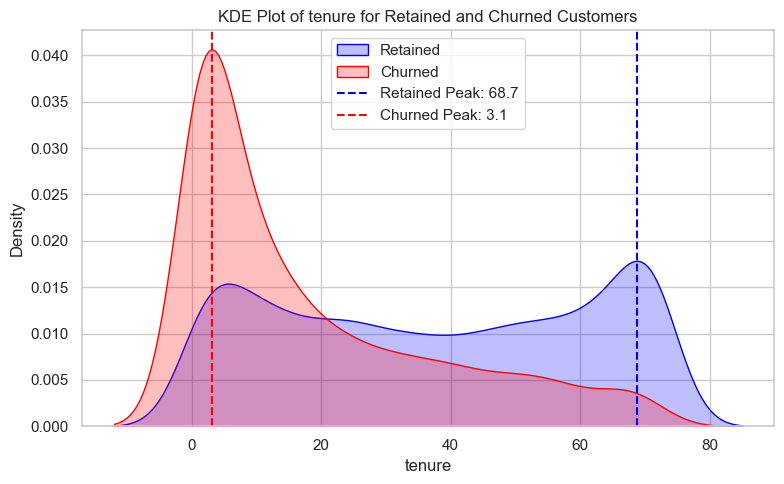

In [18]:
# KDE plot for tenure
g = ['tenure']
plotKDEplot(df, g)

Inferences:
* Churned customers tend to have a shorter tenure compared to retained customers.

**Group 2 : Services signed up for**

*('PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies')*



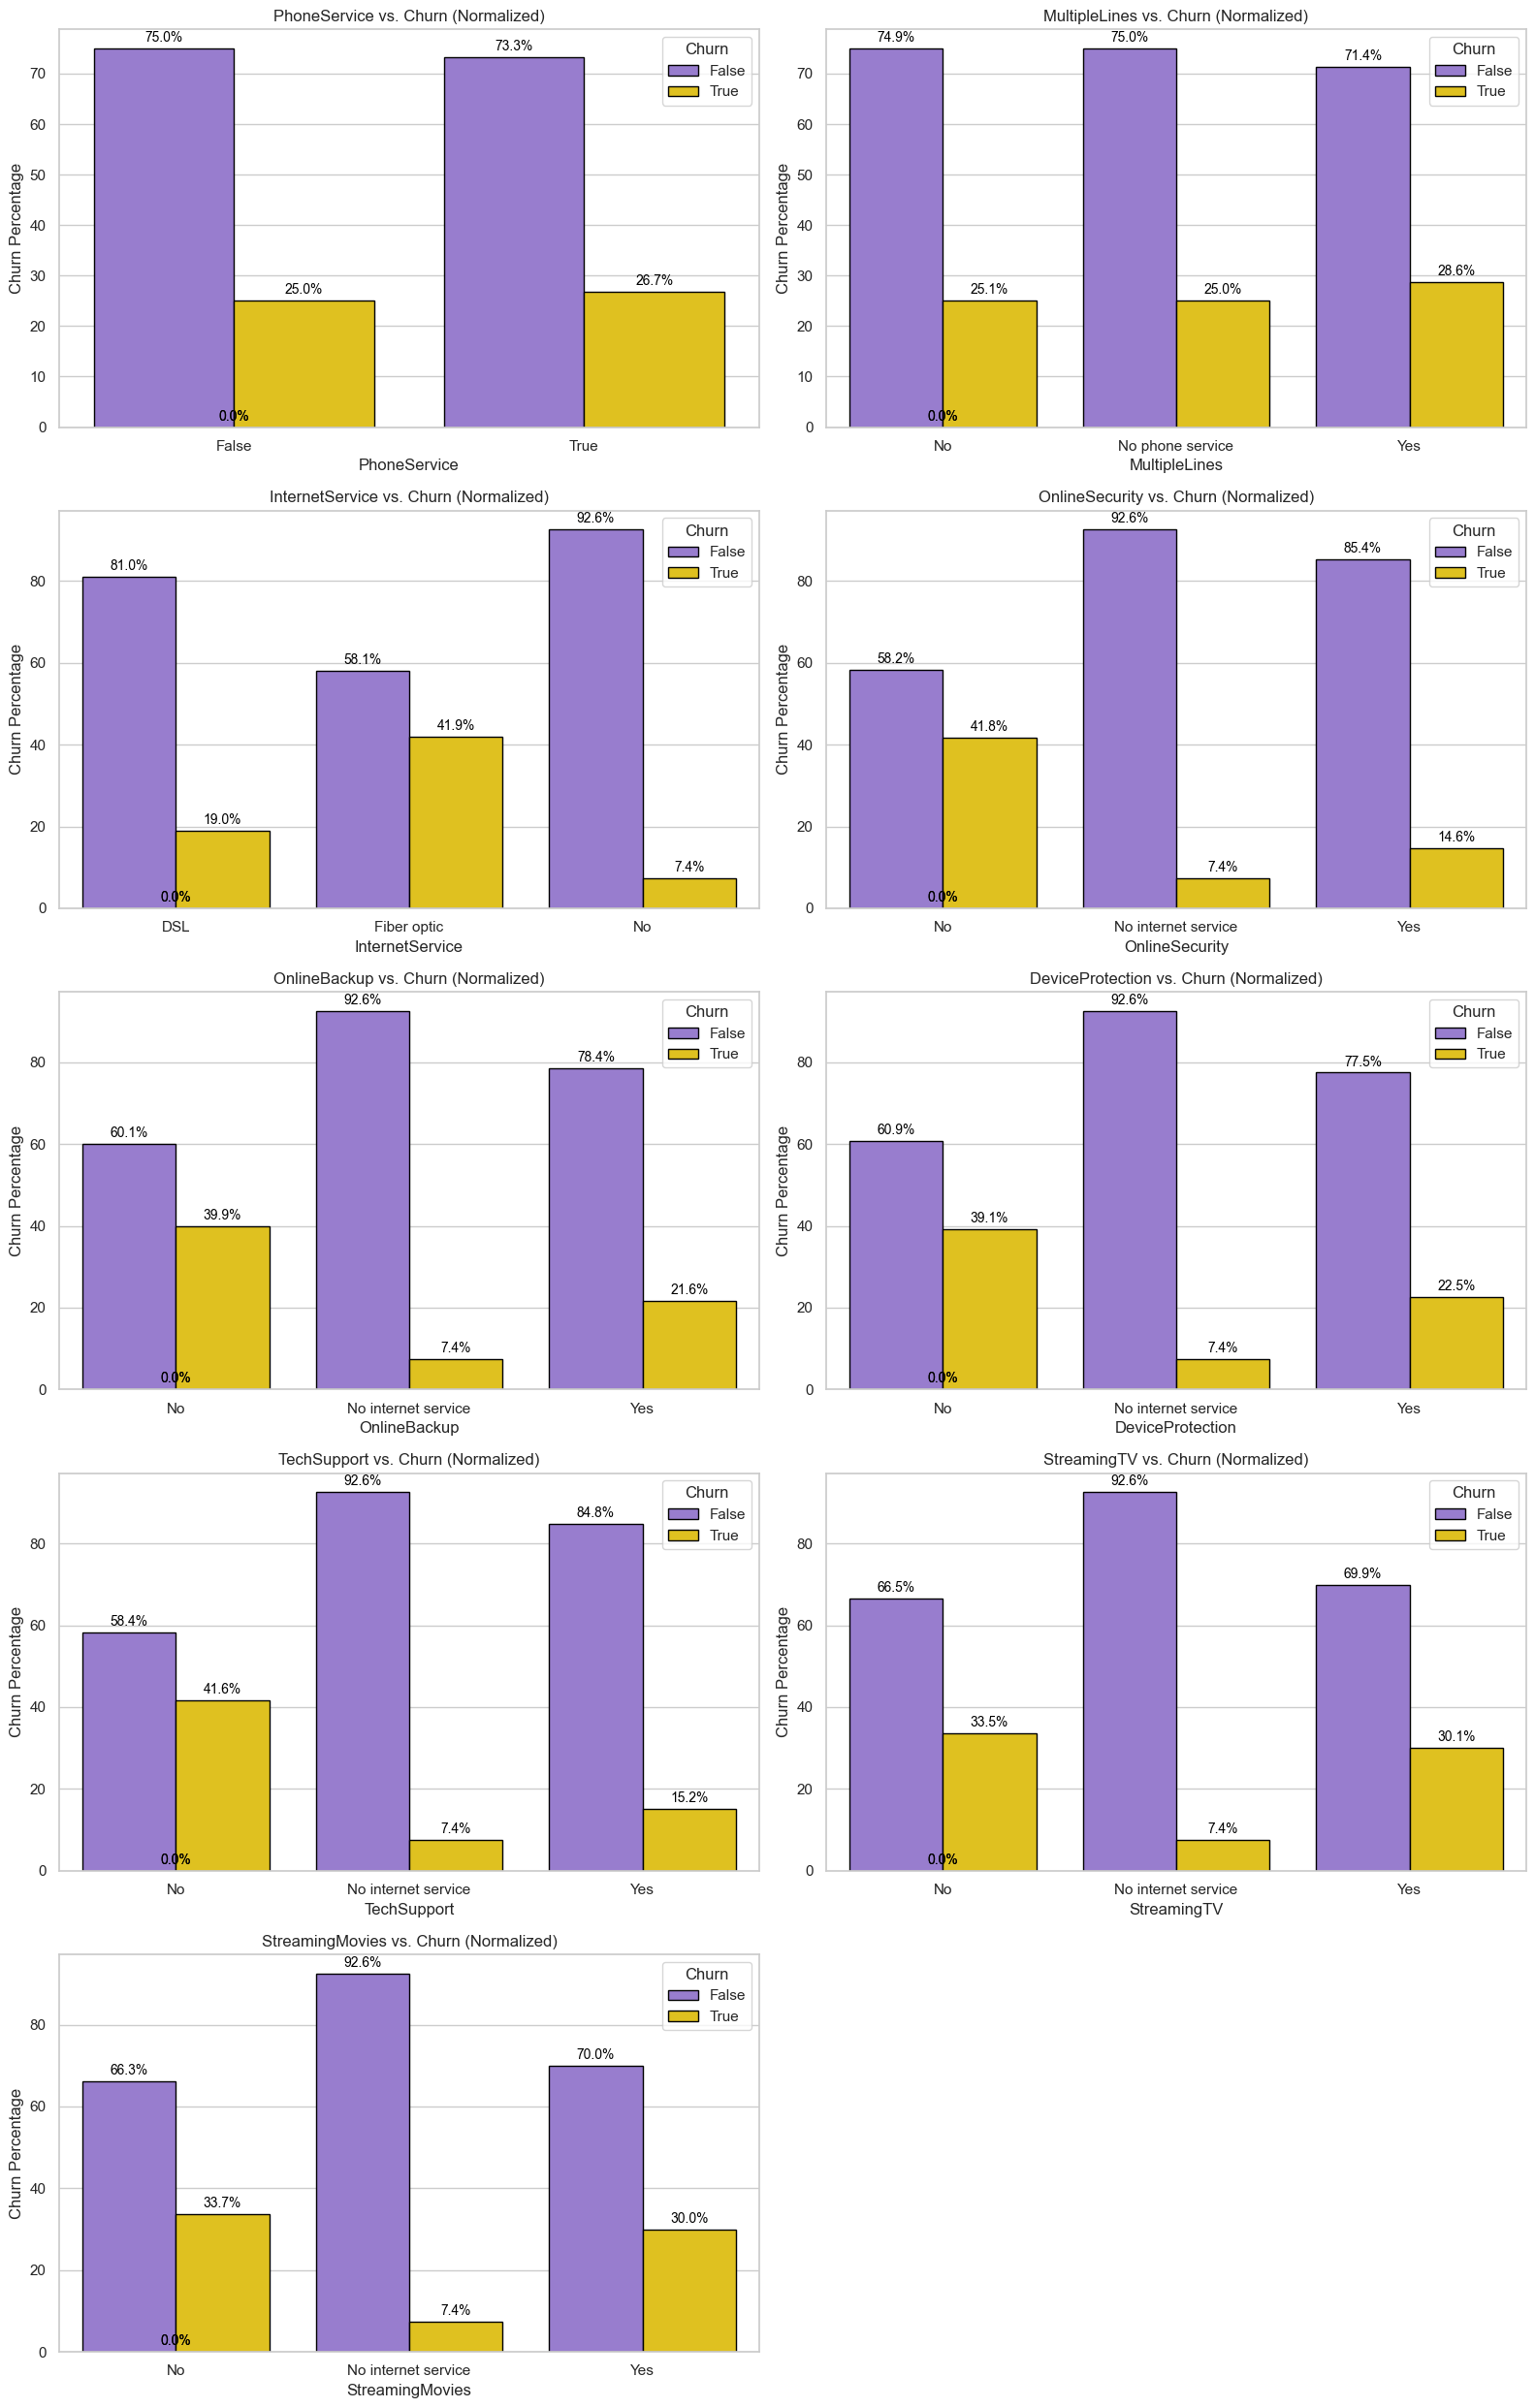

In [19]:
# Plot group2 categorized items vs Normalized Churn
plotCategory(df, group2)

Inferences:
* PhoneService does not appear to have a significant impact on customer churn.
* Having MultipleLines appears to only slightly increase the likelihood of customer churn.
* InternetService seems to have a significant impact on customer churn, particularly Fiber optic Internet service, which appears to significantly increase the likelihood of customer churn.
* Not having OnlineSecurity, OnlineBackup, DeviceProtection, and TechSupport appears to significantly increase the likelihood of customer churn.
* Not having StreamingTV or StreamingMovies appears to slightly increase the likelihood of customer churn.


**Group 3 : Payment**

*('Contract', 'PaperlessBilling', 'PaymentMethod', 'MonthlyCharges', 'TotalCharges')*



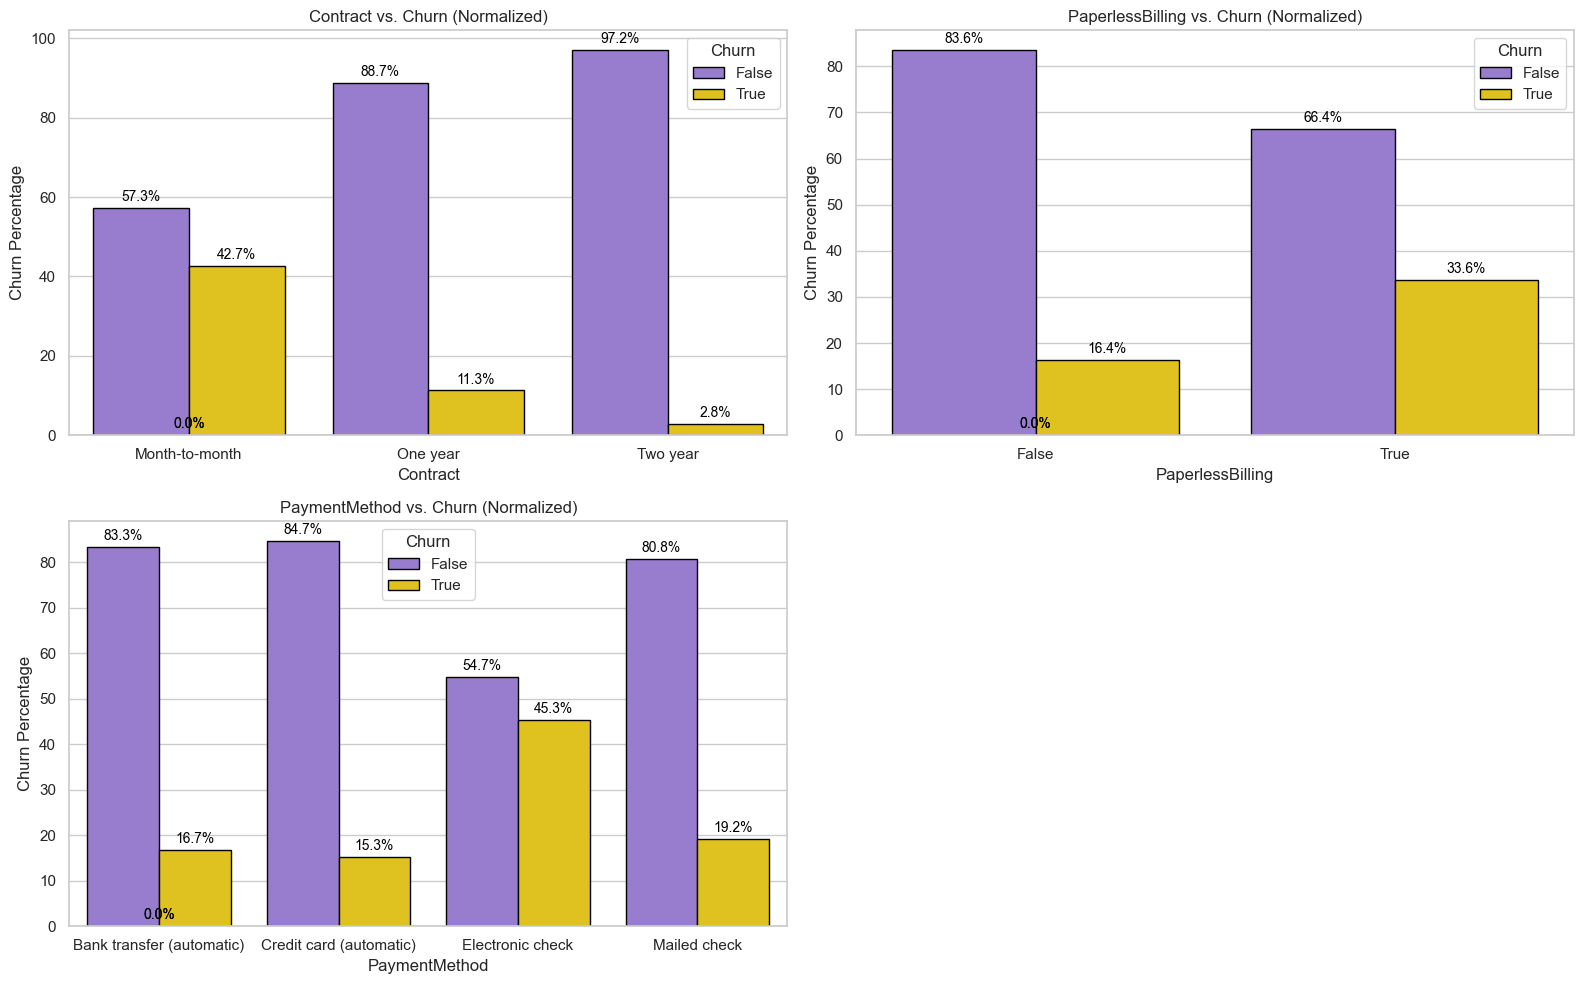

In [20]:
# Plot g3 categorized items vs Normalized Churn (except 'MonthlyCharges' and 'TotalCharges')
g3 = ['Contract', 'PaperlessBilling', 'PaymentMethod']
plotCategory(df, g3)

Inferences:
* Customers with a month-to-month contract are more likely to churn compared to customers with one year and two year contracts.
* Not having paperless billing is associated with a lower likelihood of churn.
* Customers who use electronic check as their payment method are more likely to churn compared to customers who use other payment options.


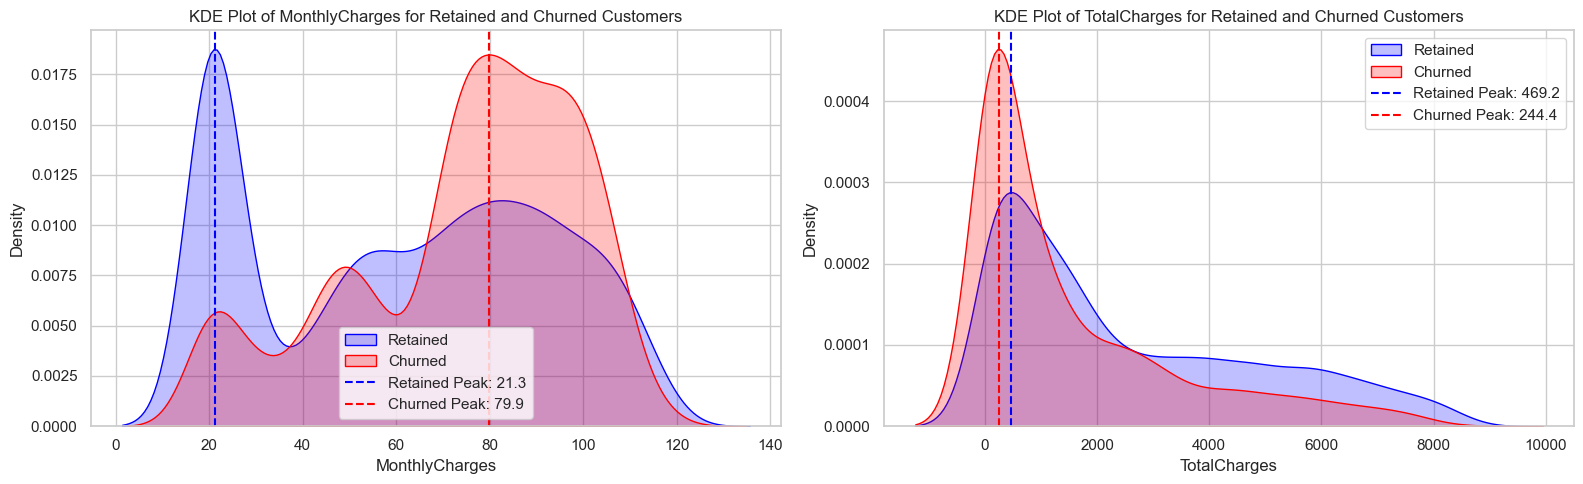

In [21]:
# KDE plot for MonthlyCharges and TotalCharges
g = ['MonthlyCharges', 'TotalCharges']
plotKDEplot(df, g)

Inferences:
* Churned customers tend to have higher Monthly Charges compared to Retained Customers.
* Churned customers have less Total Charges than Retained Customers (Possibility: due to less tenure).

Total Monthly Revenue loss

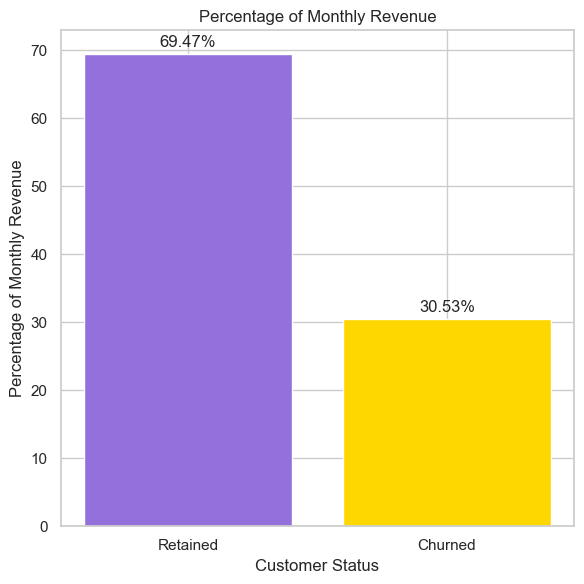

In [22]:
# Calculate the total amount of monthly charges for each churn group
churn_monthly_charges = df.groupby('Churn')['MonthlyCharges'].sum()

# Calculate the percentage of monthly revenue lost by churn customers
churn_percentage = (churn_monthly_charges[1] / (churn_monthly_charges[0] + churn_monthly_charges[1])) * 100

# Create a bar chart to visualize the percentage of monthly revenue for each group
fig, ax = plt.subplots(figsize=(6, 6))
bars = ax.bar(['Retained', 'Churned'], [100 - churn_percentage, churn_percentage], color=colors)
ax.set_title('Percentage of Monthly Revenue')
ax.set_xlabel('Customer Status')
ax.set_ylabel('Percentage of Monthly Revenue')
# Add the percentage values at the top of each bar
for bar in bars:
  height = bar.get_height()
  ax.annotate(f'{height:.2f}%', xy=(bar.get_x() + bar.get_width() / 2, height),
              xytext=(0, 3), textcoords="offset points", ha='center', va='bottom')
plt.tight_layout()
plt.show()

Inferences:
* Customers who churned resulted in a reduction of 30% in the total revenue.

**Heatmap of the Correlation Matrix**

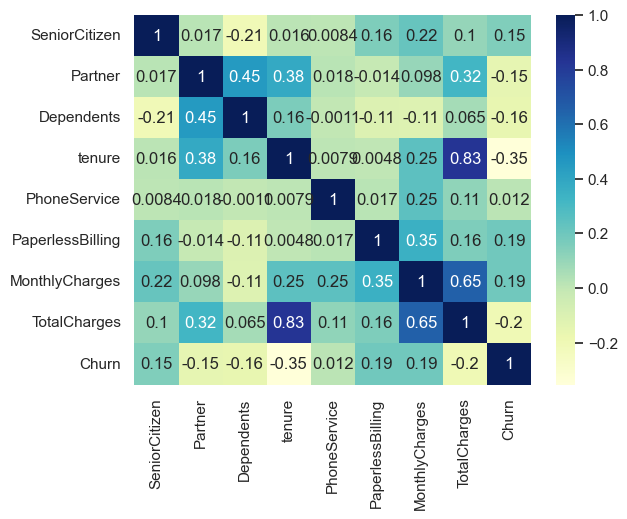

In [23]:
# Plot a heatmap
corr_matrix = df.corr(numeric_only=True) # Create a correlation matrix
sns.heatmap(corr_matrix, annot=True, cmap="YlGnBu")
plt.show()

Inferences:
* Senior citizens tend to have slightly higher monthly charges.
* Customers who have a partner are more likely to have dependents.
* Customers who have been with the company for a longer time are more likely to have a partner or dependents.
* Customers who have phone service tend to have higher monthly charges.
* Customers who use paperless billing tend to have higher monthly and total charges.
* Customers who have higher monthly charges tend to accumulate higher total charges over time.
* Customers who have been with the company for a longer time are less likely to churn.
* Customers who have higher total charges are slightly less likely to churn.

Feature selection tips:
* TotalCharges and tenure have high positive correlation, with tenure vs Churn having a higher magnitude of negative correlation compared to TotalCharges vs Churn. Thus, tenure might be a stronger predictor of Churn compared to TotalCharges.


**Few Bivariate Comparisons**




In [24]:
# Plot heatmap for the cross-tabulation between 2 features
def plotCrossTab(df, x1, x2):
  # Calculate the cross-tabulation between x1 and x2
  cross_tab = pd.crosstab(df[x1], df[x2])
  # Plot the heatmap
  fig, ax = plt.subplots(figsize=(6, 4))
  sns.heatmap(cross_tab, annot=True, fmt='d', cmap='coolwarm', linewidths=0.5, ax=ax)
  plt.title(f"{x1} vs {x2}")
  plt.xlabel(f"{x2}")
  plt.ylabel(f"{x1}")
  plt.show()

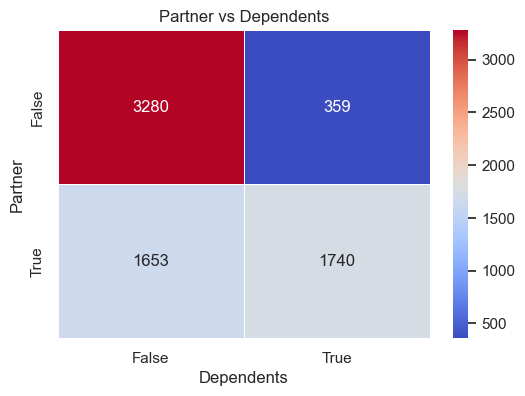

In [25]:
# Comparison between Partner and Dependents
plotCrossTab(df, 'Partner', 'Dependents')

Inferences:
* Customers with no partner are less likely to have dependents.
* Customers with a partner are more likely to have dependents.



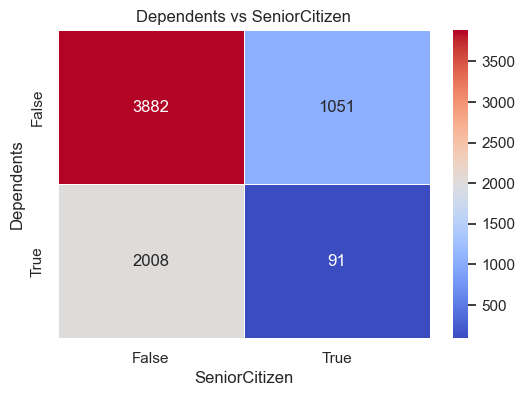

In [26]:
# Comparison between Dependents and SeniorCitizen
plotCrossTab(df, 'Dependents', 'SeniorCitizen')

Inferences:
* Senior citizens mostly do not have dependents.
* Non-senior citizens tend to have a higher proportion of customers without dependents compared to those with dependents.


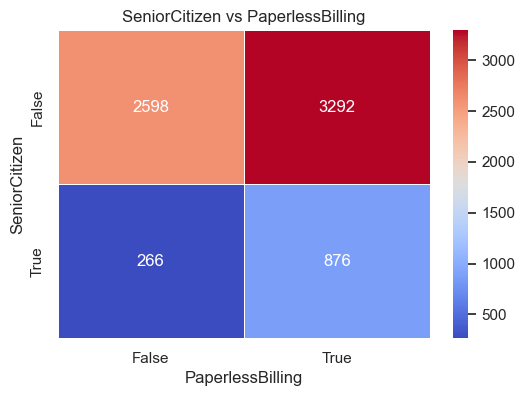

In [27]:
# Comparison between SeniorCitizen and PaperlessBilling
plotCrossTab(df, 'SeniorCitizen', 'PaperlessBilling')

Inferences:
* Majority of non-senior customers use paperless billing.
* Among senior citizens, there are still more customers who use paperless billing than those who do not.



# Feature Selection

**Chi-square test results for categorical features**


In [28]:
# Select the categorical columns
categorical_columns = ['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines',
                       'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
                       'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod']
chi2_results = []
# Perform Chi-square test for each categorical feature against 'Churn'
for col in categorical_columns:
  cross_tab = pd.crosstab(df[col], df['Churn'])
  chi2, p_value, _, _ = chi2_contingency(cross_tab)
  chi2_results.append([col, chi2, p_value])

# Create a DataFrame to display the results in a tabular format
chi2_results_df = pd.DataFrame(chi2_results, columns=['Feature', 'Chi2', 'P-value'])
# sort the results by p-value
chi2_results_df.sort_values('P-value', inplace=True)
print(chi2_results_df)

             Feature         Chi2        P-value
13          Contract  1179.545829  7.326182e-257
7     OnlineSecurity   846.677389  1.400687e-184
10       TechSupport   824.925564  7.407808e-180
6    InternetService   728.695614  5.831199e-159
15     PaymentMethod   645.429900  1.426310e-139
8       OnlineBackup   599.175185  7.776099e-131
9   DeviceProtection   555.880327  1.959389e-121
12   StreamingMovies   374.268432   5.353560e-82
11       StreamingTV   372.456502   1.324641e-81
14  PaperlessBilling   256.874908   8.236203e-58
3         Dependents   186.321639   2.019659e-42
1      SeniorCitizen   158.440816   2.479256e-36
2            Partner   157.503151   3.973798e-36
5      MultipleLines    11.271541   3.567927e-03
4       PhoneService     0.873733   3.499240e-01
0             gender     0.475455   4.904885e-01


Inference:
* Gender and PhoneService do not significantly affect Churn, as indicated by their P-values (> 0.05). Therefore, these features can be dropped from the analysis.

In [29]:
# # Drop the fields gender and PhoneService
df = df.drop('gender', axis=1)
df = df.drop('PhoneService', axis=1)

# Data Preprocessing


To tackle class imbalance, we take the following steps:

* One-hot encode categorical features, dropping the first category of each feature to avoid multicollinearity.
* Split the dataset into training and testing sets (80:20 ratio) for evaluating model performance on unseen data.
* Apply Synthetic Minority Over-sampling Technique (SMOTE) to oversample the minority class (churning customers) and balance the target variable ('Churn') in the training set.
* Apply Edited Nearest Neighbor (ENN) technique to remove noisy samples from the majority class (non-churning customers).

In [30]:
# One-hot encode the categorical features
df_encoded = pd.get_dummies(df, drop_first=True)
X = df_encoded.drop(columns='Churn')
y = df_encoded['Churn']

# Split the dataset into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Apply SMOTE to the training set
smote = SMOTE(sampling_strategy='auto', random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# Apply ENN to the SMOTE output
enn = EditedNearestNeighbours(sampling_strategy='all',n_jobs= -1)
X_train_smote_enn, y_train_smote_enn = enn.fit_resample(X_train_smote, y_train_smote)

# Create a DataFrame from the SMOTE-ENN output
X_train_smote_enn_df = pd.DataFrame(X_train_smote_enn, columns=X_train.columns)
y_train_smote_enn_df = pd.Series(y_train_smote_enn)

# Display the counts of the target variable before and after SMOTE and ENN
print("Before SMOTE:\n", y_train.value_counts())
print("\nAfter SMOTE:\n", y_train_smote.value_counts())
print("\nAfter SMOTE and ENN:\n", y_train_smote_enn_df.value_counts())

Before SMOTE:
 Churn
False    4130
True     1495
Name: count, dtype: int64

After SMOTE:
 Churn
True     4130
False    4130
Name: count, dtype: int64

After SMOTE and ENN:
 Churn
True     2477
False    2139
Name: count, dtype: int64


# Feature Scaling

* Continuous features such as tenure, MonthlyCharges, and TotalCharges are scaled using standard scaling to ensure that they contribute equally to the model. This helps the model converge faster and avoids any one feature from dominating the other features.
* We apply standard scaling to these features, transforming them to have a mean of 0 and a standard deviation of 1.

In [31]:
# Define the numeric features
numeric_features = ['tenure', 'MonthlyCharges', 'TotalCharges']

# Instantiate the standard scaler
scaler = StandardScaler()

# Fit the scaler on the numeric features of the training set (SMOTE-ENN output)
X_train_smote_enn_df[numeric_features] = scaler.fit_transform(X_train_smote_enn_df[numeric_features])

# Transform the numeric features of the test set using the same scaler
X_test[numeric_features] = scaler.transform(X_test[numeric_features])

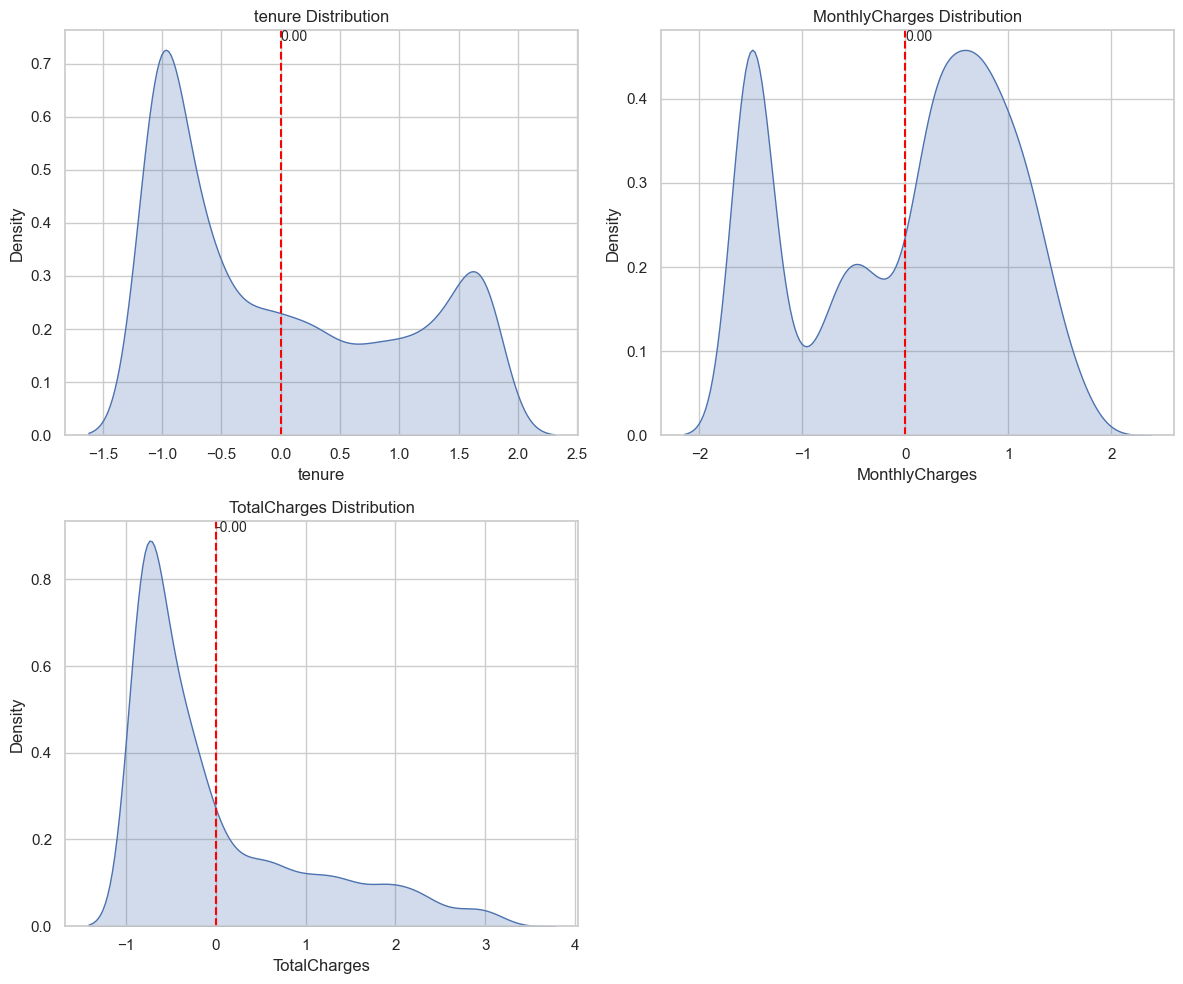

In [32]:
# Plot the distribution of the numeric features
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 10))
axes = axes.ravel()
numeric_features = ['tenure', 'MonthlyCharges', 'TotalCharges']
for i, feature in enumerate(numeric_features):
    sns.kdeplot(X_train_smote_enn_df[feature], ax=axes[i], fill=True)
    axes[i].set_title(f'{feature} Distribution')
    axes[i].set_xlabel(feature)
    axes[i].set_ylabel('Density')
    # Get peak value and plot it on x-axis
    peak_val = X_train_smote_enn_df[feature].mean()
    axes[i].axvline(x=peak_val, color='red', linestyle='--')
    axes[i].text(peak_val, axes[i].get_ylim()[1], f'{peak_val:.2f}', fontsize=10, va='top')
fig.delaxes(axes[-1])
plt.tight_layout()
plt.show()

# Machine Learning Models using sklearn

Helper functions

In [33]:
modelDict = {}

def getEvalMetrics(modelName, conf_matrices):
  # Calculate the average confusion matrix
  avg_conf_matrix = np.mean(conf_matrices, axis=0)

  # Calculate the sum of all elements in the confusion matrix
  total = np.sum(avg_conf_matrix)

  # Calculate the true positives, true negatives, false positives, and false negatives
  tp = avg_conf_matrix[1, 1]
  tn = avg_conf_matrix[0, 0]
  fp = avg_conf_matrix[0, 1]
  fn = avg_conf_matrix[1, 0]

  # Calculate the accuracy, true positive rate, and false positive rate
  accuracy = (tp + tn) / total
  tpr = tp / (tp + fn)
  fpr = fp / (fp + tn)
  # Calculate the precision, recall and F1 score
  precision = tp / (tp + fp)
  recall = tp / (tp + fn)
  f1_score = 2 * precision * recall / (precision + recall)

  # Store metrics
  modelDict[modelName] = {}
  modelDict[modelName]['Accuracy'] = accuracy
  modelDict[modelName]['True Positive Rate'] = tpr
  modelDict[modelName]['False Positive Rate'] = fpr
  modelDict[modelName]['F1 Score'] = f1_score

  # Print the results
  print("\nAccuracy:", accuracy)
  print("True Positive Rate:", tpr)
  print("False Positive Rate:", fpr)
  print("F1 Score:", f1_score)

# Plot confusion matrix
def plot_conf_matrix(conf_matrix, classes, title, cmap=plt.cm.Blues):
  fig, ax = plt.subplots()
  im = ax.imshow(conf_matrix, interpolation='nearest', cmap=cmap)
  ax.figure.colorbar(im, ax=ax)
  ax.set(xticks=np.arange(conf_matrix.shape[1]),
          yticks=np.arange(conf_matrix.shape[0]),
          xticklabels=classes, yticklabels=classes,
          title=title,
          ylabel='True label',
          xlabel='Predicted label')
  ax.set_xticks([], [])
  ax.set_yticks([], [])
  fmt = '.2f'
  thresh = conf_matrix.max() / 2.
  for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
      ax.text(j, i, format(conf_matrix[i, j], fmt),
              ha="center", va="center",
              color="white" if conf_matrix[i, j] > thresh else "black")
  fig.tight_layout()
  plt.show()

def trainTestAndPlot(modelName, model):
  conf_matrices = []
  # Define the cross-validation method
  cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=39)

  # Perform cross-validation
  for train_index, test_index in cv.split(X, y):
    # Split the data into training and test sets
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Apply SMOTE and ENN to the training set
    X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)
    X_train_smote_enn, y_train_smote_enn = enn.fit_resample(X_train_smote, y_train_smote)

    # Create a DataFrame from the SMOTE-ENN output
    X_train_smote_enn_df = pd.DataFrame(X_train_smote_enn, columns=X_train.columns)
    y_train_smote_enn_df = pd.Series(y_train_smote_enn)

    # Fit the model to the training data
    model.fit(X_train_smote_enn_df, y_train_smote_enn_df)

    # Predict on the test data
    y_pred = model.predict(X_test)

    # Append the confusion matrix to the list
    conf_matrices.append(confusion_matrix(y_test, y_pred))

  # Print details
  getEvalMetrics(modelName, conf_matrices)

  # Calculate the average confusion matrix
  avg_conf_matrix = np.mean(conf_matrices, axis=0)
  # Plot the confusion matrix
  plot_conf_matrix(avg_conf_matrix, classes=['0', '1'], title=f"{modelName} - Confusion Matrix")

  # Plot the ROC curve
  fpr, tpr = 0, 0
  if modelName == 'Stochastic Gradient Descent Classifier':
    # Use decision_function instead of predict_proba
    y_score = model.decision_function(X_test)
    fpr, tpr, _ = roc_curve(y_test, y_score)
  else:
    y_pred_prob = model.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
  roc_auc = auc(fpr, tpr)
  print(f"\nArea under ROC Curve: {roc_auc}\n")
  # modelDict[modelName]['Area under ROC Curve'] = roc_auc
  plt.figure()
  lw = 2
  plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
  plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title(f'{modelName} - ROC Curve')
  plt.legend(loc="lower right")
  plt.show()

# **1. Logistic Regression**

In [34]:
X_train_smote_enn.shape

(4616, 28)


Accuracy: 0.7458759954493743
True Positive Rate: 0.7645799892990904
False Positive Rate: 0.2608948285880302
F1 Score: 0.6152852529601722


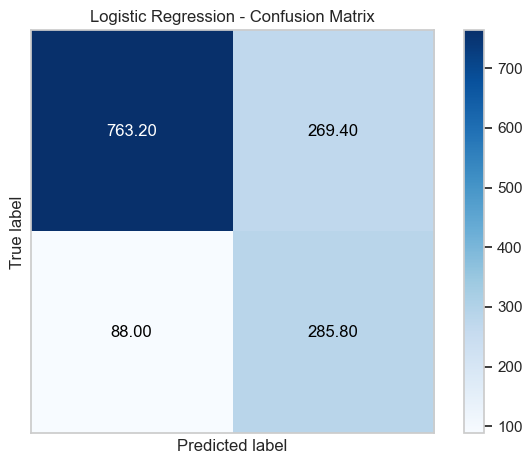


Area under ROC Curve: 0.8290700265306968



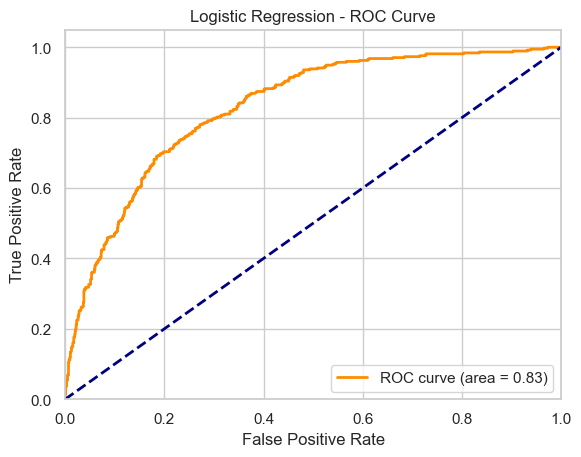

In [35]:
# Create a logistic regression object
logreg = LogisticRegression(random_state=39)

# Train and test the model, and print evaluation metrics
trainTestAndPlot('Logistic Regression', logreg)


# **2. K-Nearest Neighbors (KNN)**


Accuracy: 0.7007963594994312
True Positive Rate: 0.7191011235955056
False Positive Rate: 0.305829943831106
F1 Score: 0.5609348914858096


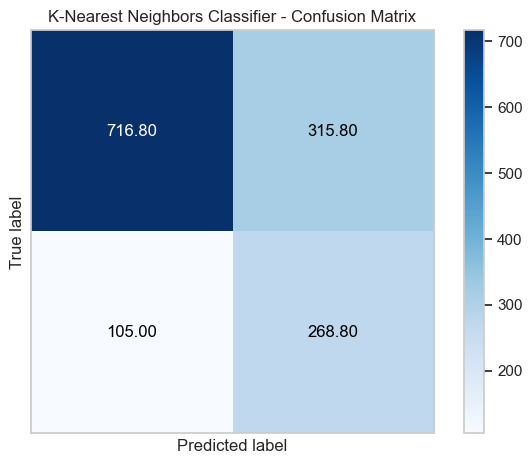


Area under ROC Curve: 0.7403165547402892



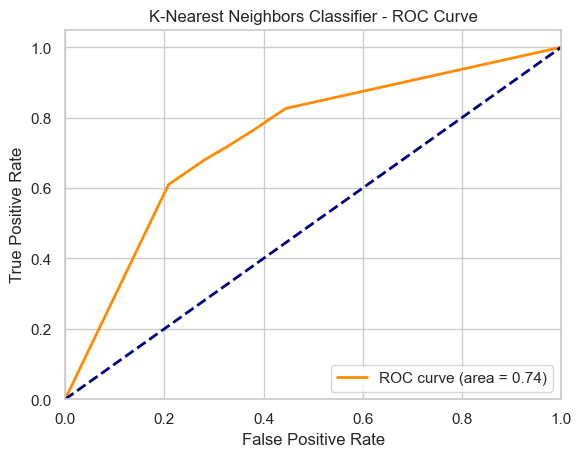

In [36]:
# Define the kNN model
knn_model = KNeighborsClassifier()

# Train and test the model, and print evaluation metrics
trainTestAndPlot('K-Nearest Neighbors Classifier', knn_model)

# **3. Support Vector Machines (SVM)**


Accuracy: 0.6858646188850968
True Positive Rate: 0.6784376672017121
False Positive Rate: 0.3114468332364905
F1 Score: 0.5344573234984193


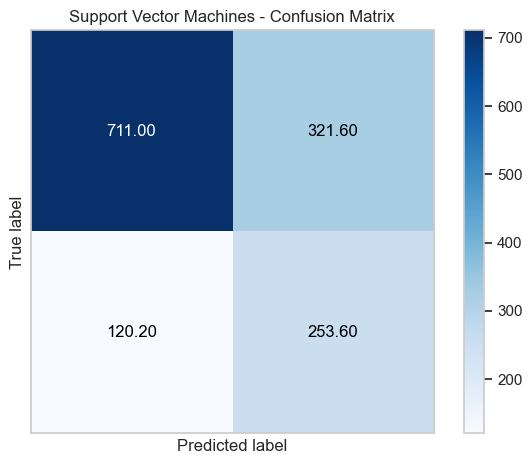


Area under ROC Curve: 0.7372618973593666



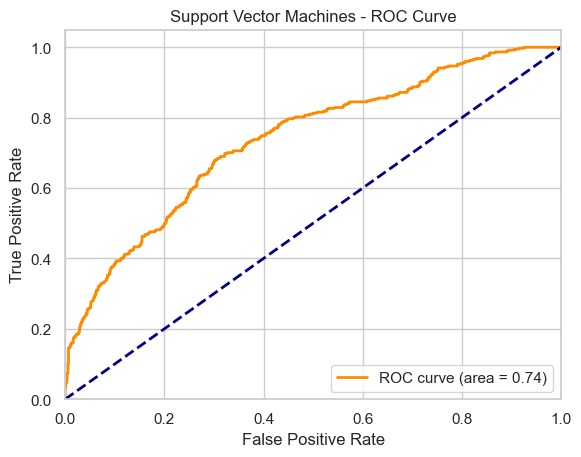

In [37]:
# Define the SVM model
svm_model = SVC(probability=True, random_state=39)

# Train and test the model, and print evaluation metrics
trainTestAndPlot('Support Vector Machines', svm_model)

# **4. Random Forest**

In [38]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, f1_score

rf_model = RandomForestClassifier(random_state=39)
# Hyperparameter grid
rf_params = {
    'n_estimators': [50, 100, 200],
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 5, 8,10],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'class_weight': ['balanced']
}
# F1 scorer (works better with imbalanced data like churn)
f1 = make_scorer(f1_score)

# Grid search
grid = GridSearchCV(rf_model,rf_params, cv=3, scoring=f1, n_jobs=-1, verbose=2)

# Fit the model
grid.fit(X_train_smote_enn, y_train_smote_enn)

# Output best parameters and score
print("Best Parameters:", grid.best_params_)
print("Best F1 Score:", grid.best_score_)

Fitting 3 folds for each of 96 candidates, totalling 288 fits
Best Parameters: {'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Best F1 Score: 0.9515158668111422



Accuracy: 0.7542662116040956
True Positive Rate: 0.7833065810593901
False Positive Rate: 0.2562463683904707
F1 Score: 0.6288659793814433


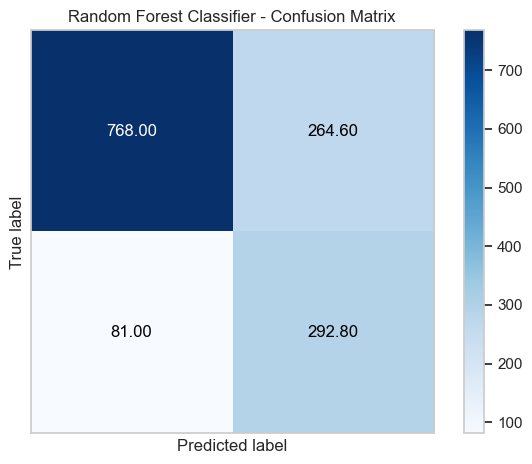


Area under ROC Curve: 0.835628860423662



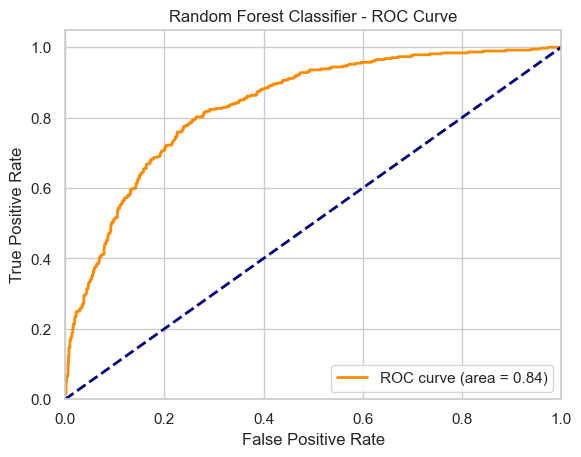

In [39]:
# Define the Random Forest model
rf_model = RandomForestClassifier(random_state=42,n_estimators=50, max_depth=6,criterion='gini',class_weight='balanced',min_samples_leaf=1)

# Train and test the model, and print evaluation metrics
trainTestAndPlot('Random Forest Classifier', rf_model)

**Why was this algorithm chosen ?**

Random forests can capture non linear relationships that are present in the customer churn dataset and it also provides feature importance rankings.

**How does this algorithm perform on our dataset?**
The model exhibits a not so bad accuracy with a high TPR of 0.77 and low FPR 0.25 this indicates that the model effectively predicts the customers who will churn and not churn. F1 score is relatively better than the above models.

# **5. Decision Tree**


Accuracy: 0.7416097838452788
True Positive Rate: 0.7645799892990904
False Positive Rate: 0.26670540383497965
F1 Score: 0.611336898395722


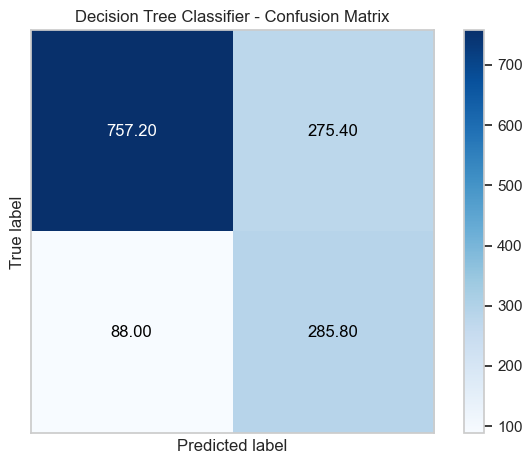


Area under ROC Curve: 0.802639078887369



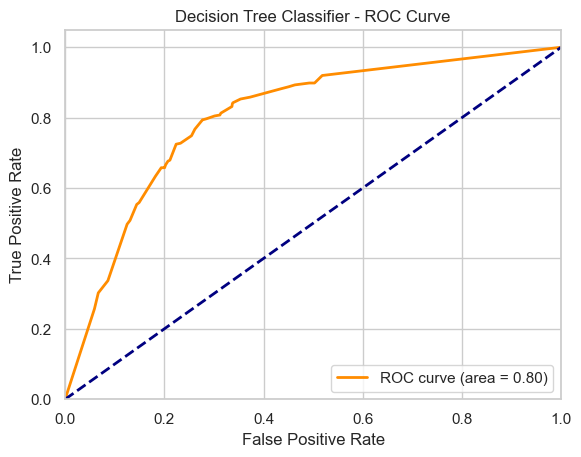

In [40]:
# Define the Decision Tree model
tree_model = DecisionTreeClassifier(random_state=39,max_depth=7)

# Train and test the model, and print evaluation metrics
trainTestAndPlot('Decision Tree Classifier', tree_model)

# **6. Naive Bayes**


Accuracy: 0.6407849829351536
True Positive Rate: 0.8924558587479936
False Positive Rate: 0.45031958163858227
F1 Score: 0.5690890481064483


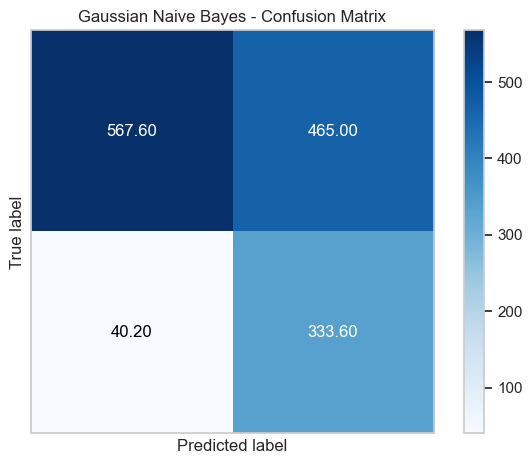


Area under ROC Curve: 0.8070837478754715



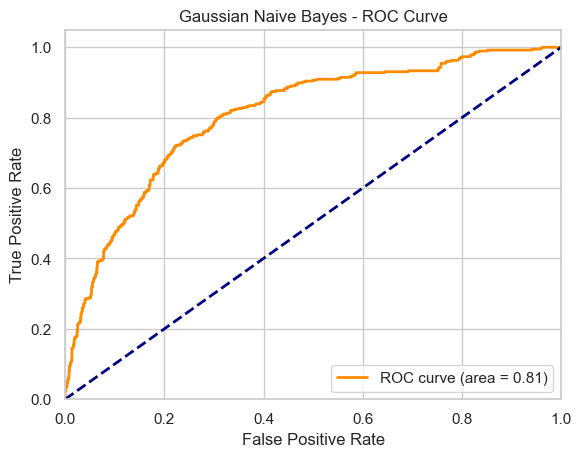

In [41]:
# Define the Naive Bayes model
nb_model = GaussianNB()

# Train and test the model, and print evaluation metrics
trainTestAndPlot('Gaussian Naive Bayes', nb_model)

# **7. Kernel SVM**


Accuracy: 0.6858646188850968
True Positive Rate: 0.6784376672017121
False Positive Rate: 0.3114468332364905
F1 Score: 0.5344573234984193


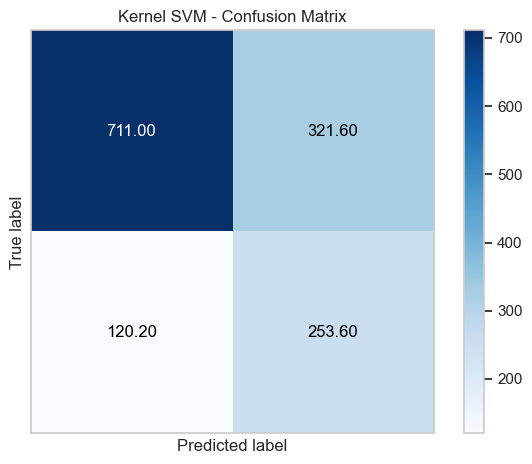


Area under ROC Curve: 0.7372618973593666



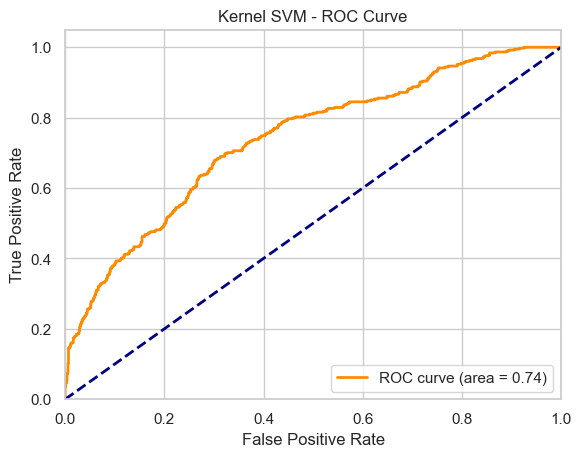

In [42]:
# Define the SVM model
ksvm_model = SVC(kernel='rbf', probability=True, random_state=39)

# Train and test the model, and print evaluation metrics
trainTestAndPlot('Kernel SVM', ksvm_model)

# **8. Artificial Neural Network (ANN)**


Accuracy: 0.715301478953356
True Positive Rate: 0.7426431246655966
False Positive Rate: 0.29459616502033703
F1 Score: 0.5809962327333612


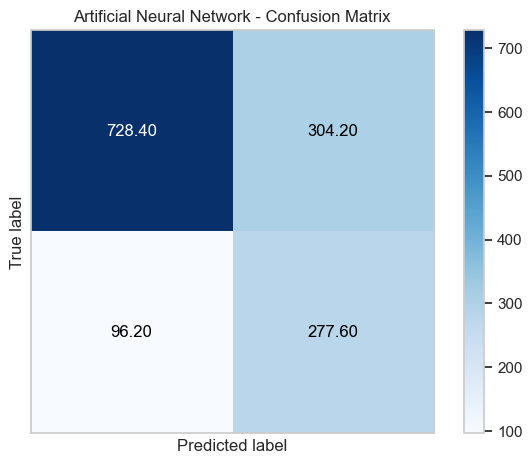


Area under ROC Curve: 0.744749564730755



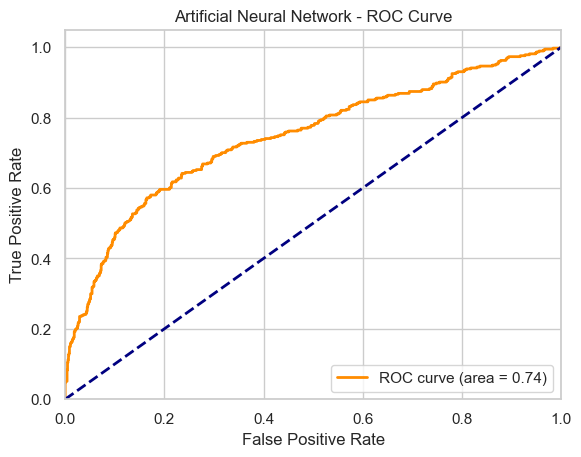

In [43]:
# Define the ANN model
ann_model = MLPClassifier(random_state=39)

# Train and test the model, and print evaluation metrics
trainTestAndPlot('Artificial Neural Network', ann_model)

# **9.Xgboost(XGB)**

In [44]:
from xgboost import XGBClassifier


Accuracy: 0.7600967007963595
True Positive Rate: 0.7110754414125201
False Positive Rate: 0.22215766027503386
F1 Score: 0.6117376294591484


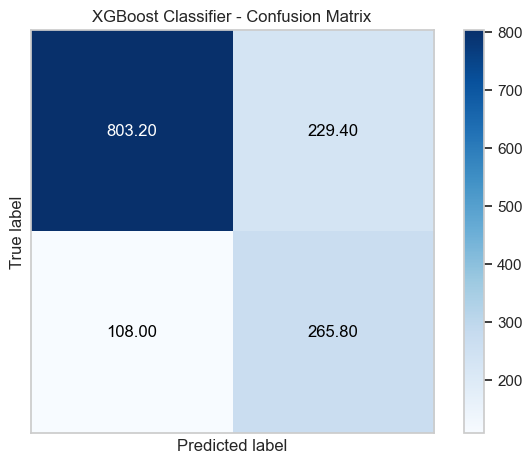


Area under ROC Curve: 0.8156064751481988



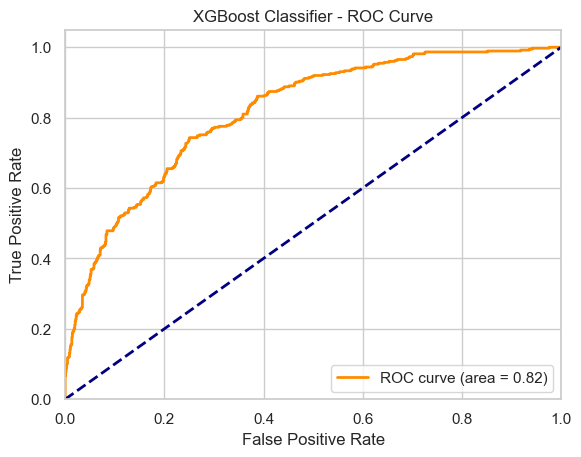

In [45]:
xgb = XGBClassifier()

trainTestAndPlot('XGBoost Classifier', xgb)

# **10.Voting Classifier**

In [46]:
from sklearn.ensemble import VotingClassifier

ensemble = VotingClassifier(estimators=[
    ('logreg', logreg),
    ('rf', rf_model),
    ('dt',tree_model),
    ('nb' , nb_model),
    ('ann', ann_model)
], voting='soft',n_jobs=-1)


Accuracy: 0.7369169510807736
True Positive Rate: 0.8063135366506153
False Positive Rate: 0.2882045322486927
F1 Score: 0.6196546052631577


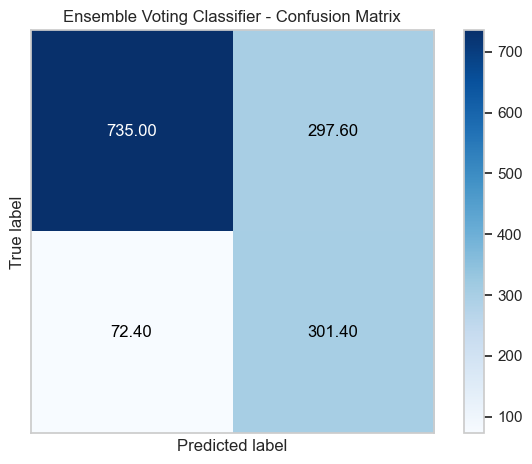


Area under ROC Curve: 0.8346145276292336



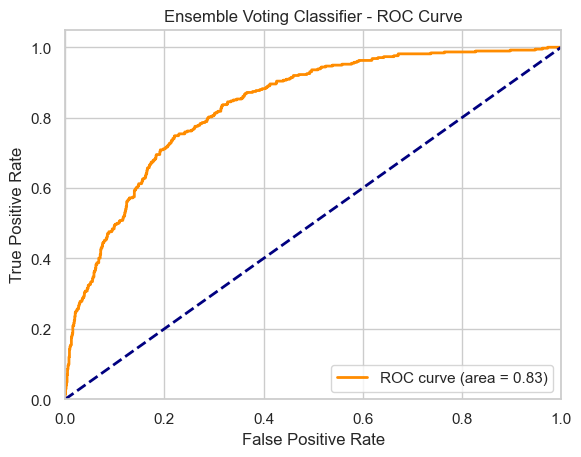

In [47]:
model = ensemble

trainTestAndPlot('Ensemble Voting Classifier', model)

# Comparing Models

# **11.Stacking Classifier**

In [48]:
from sklearn.ensemble import StackingClassifier

stack = StackingClassifier(
    estimators = [
        ('rfc',rf_model),
        ('xgb', xgb),
        ('dt', tree_model),
        
    ],
    final_estimator= LogisticRegression(),
    cv = 5,
    n_jobs = -1
)



Accuracy: 0.763509670079636
True Positive Rate: 0.7335473515248797
False Positive Rate: 0.2256440054232036
F1 Score: 0.6224744608399546


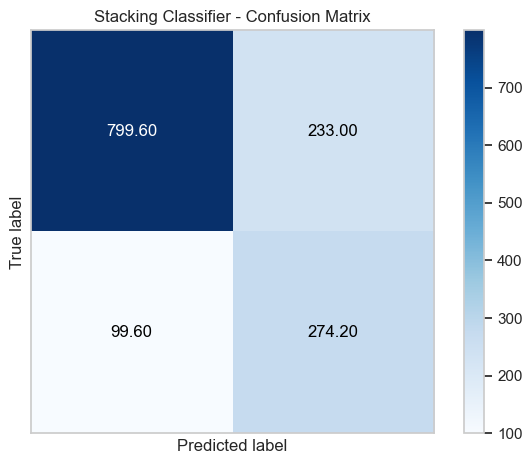


Area under ROC Curve: 0.8291347987397919



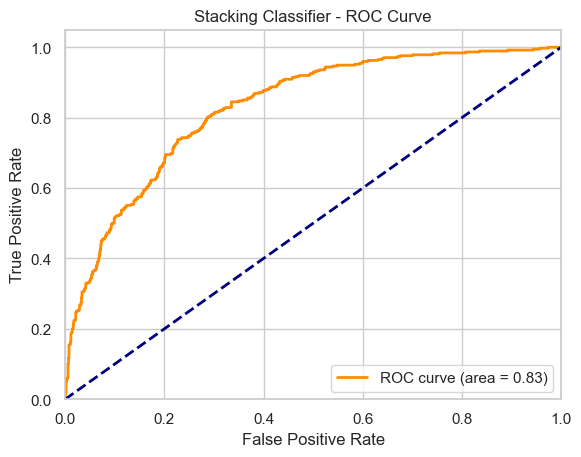

In [49]:
trainTestAndPlot('Stacking Classifier', stack)

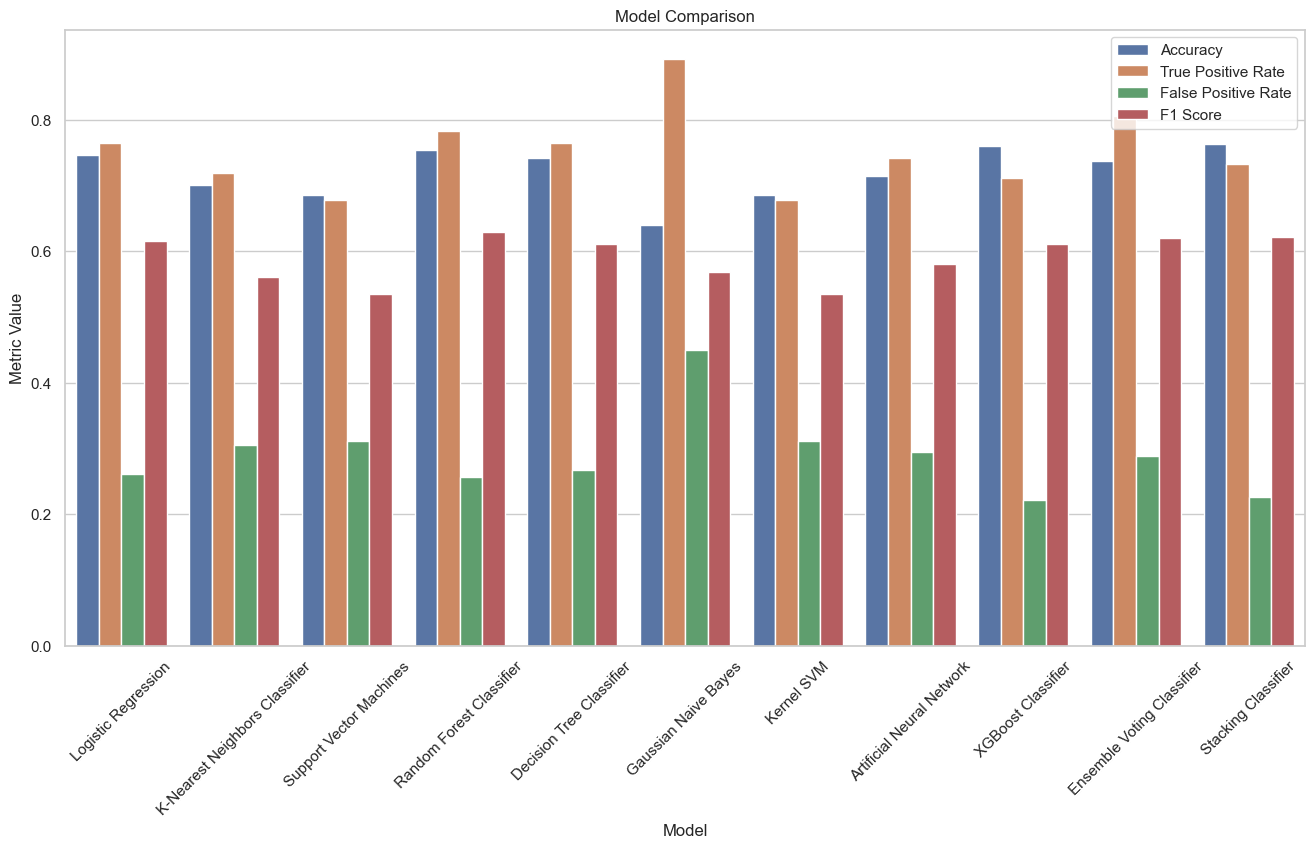

In [50]:
# Plot and compare
# Convert the modelDict to a pandas DataFrame
model_df = pd.DataFrame(modelDict).T.reset_index().rename(columns={"index": "Model"})
melted_df = model_df.melt(id_vars=['Model'], var_name='Metric', value_name='Value')
# Create a bar plot
plt.figure(figsize=(16, 8))
sns.barplot(x='Model', y='Value', hue='Metric', data=melted_df)
plt.title('Model Comparison')
plt.xlabel('Model')
plt.ylabel('Metric Value')
plt.xticks(rotation=45)
plt.legend(loc='upper right')
plt.show()

Inferences:


*   RFC gives the best accuracy.
*   NB,RFC and ensemble have a high TPR
*   xgb,stacking has the lower FPR
*   RFC, has the highest F1 score
*   RFC has high ROC

Overall performance of RFC is better than all other algorithms. RFC captures the  complex non-linear relationships between features and Churn.

